In [25]:
import json
import pandas as pd
import h5py
import numpy as np
import tensorflow as tf
import keras
from keras.layers import Input, Dense, Dropout, LSTM, Flatten, GRU
from keras.models import Model
from keras.optimizers import Adam, SGD
from sklearn.model_selection import train_test_split
import os
import h5py
import matplotlib.pyplot as plt
from keras import regularizers
from tensorflow.keras.regularizers import l1


In [6]:
df = pd.read_hdf('data_500k')

In [7]:
features = df.values[:,0:16]

In [32]:
labels = df.values[:,16:19]

In [9]:
length = len(df)
featuresnum = 16

In [10]:
X_train, X_test, y_train, y_test = train_test_split(features,labels,test_size = 0.2, random_state = 42)


In [13]:
#images = np.stack((X_train,X_train),axis = -1)

In [23]:
images = X_train.reshape(len(X_train), 16, 1)

In [26]:
Inputs = Input(shape=(16,1))
x = LSTM(16, dropout = 0.5, kernel_initializer = 'VarianceScaling', kernel_regularizer = regularizers.l1_l2(l1= 9.999E-5, l2 = 0.0), name = 'lstm1')(Inputs)
x = Flatten(trainable= True)(x)
predictions = Dense(3, activation='softmax', kernel_initializer='lecun_uniform', name = 'output_sigmoid')(x)
model = Model(inputs=Inputs, outputs=predictions)
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 16, 1)]           0         
_________________________________________________________________
lstm1 (LSTM)                 (None, 16)                1152      
_________________________________________________________________
flatten (Flatten)            (None, 16)                0         
_________________________________________________________________
output_sigmoid (Dense)       (None, 3)                 51        
Total params: 1,203
Trainable params: 1,203
Non-trainable params: 0
_________________________________________________________________


In [27]:

adam = Adam(lr = 0.0001)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [28]:
history = model.fit(images, y_train, batch_size = 1024, epochs = 25, 
                    validation_split = 0.25, shuffle = True, callbacks = None,
                    use_multiprocessing=True, workers=4)

Epoch 1/25
833/833 [==============================] - 54s 65ms/step - loss: 0.9081 - accuracy: 0.5534 - val_loss: 0.9932 - val_accuracy: 0.4813
Epoch 2/25
833/833 [==============================] - 34s 41ms/step - loss: 0.8438 - accuracy: 0.5939 - val_loss: 0.9620 - val_accuracy: 0.4941
Epoch 3/25
833/833 [==============================] - 35s 42ms/step - loss: 0.8268 - accuracy: 0.6026 - val_loss: 0.9265 - val_accuracy: 0.5187
Epoch 4/25
833/833 [==============================] - 35s 41ms/step - loss: 0.8140 - accuracy: 0.6126 - val_loss: 0.9119 - val_accuracy: 0.5275
Epoch 5/25
833/833 [==============================] - 34s 41ms/step - loss: 0.8087 - accuracy: 0.6161 - val_loss: 0.9112 - val_accuracy: 0.5316
Epoch 6/25
833/833 [==============================] - 38s 45ms/step - loss: 0.8047 - accuracy: 0.6178 - val_loss: 0.8963 - val_accuracy: 0.5457
Epoch 7/25
833/833 [==============================] - 33s 39ms/step - loss: 0.8033 - accuracy: 0.6191 - val_loss: 0.9301 - val_accuracy:

In [29]:
imagetest = X_test.reshape(len(X_test), 16, 1)

In [30]:
def makeRoc(features_val, labels_val, labels, model, outputDir='', outputSuffix=''):
    from sklearn.metrics import roc_curve, auc
    labels_pred = model.predict(features_val)
    df = pd.DataFrame()
    fpr = {}
    tpr = {}
    auc1 = {}
    plt.figure(figsize=(10,8))       
    for i, label in enumerate(labels):
        df[label] = labels_val[:,i]
        df[label + '_pred'] = labels_pred[:,i]
        fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])
        auc1[label] = auc(fpr[label], tpr[label])
        plt.plot(fpr[label],tpr[label],label='%s tagger, AUC = %.1f%%'%(label.replace('j_',''),auc1[label]*100.))
    plt.plot([0, 1], [0, 1], lw=1, color='black', linestyle='--')
    #plt.semilogy()
    plt.xlabel("Background Efficiency")
    plt.ylabel("Signal Efficiency")
    plt.xlim([-0.05, 1.05])
    plt.ylim(0.001,1.05)
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.figtext(0.25, 0.90,'LSTM ROC Curve',fontweight='bold', wrap=True, horizontalalignment='right', fontsize=14)
    #plt.figtext(0.35, 0.90,'preliminary', style='italic', wrap=True, horizontalalignment='center', fontsize=14) 
    #plt.savefig('%sROC_%s.pdf'%(outputDir, outputSuffix))
    return labels_pred

In [34]:
labels = ['light', 'charm', 'bottom']

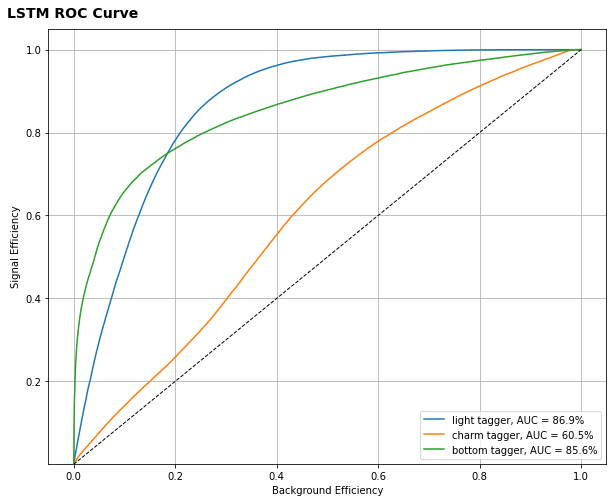

In [35]:
y_pred = makeRoc(imagetest, y_test, labels, model, outputSuffix='two-layer')

In [36]:
def learningCurve(history):
    plt.figure(figsize=(10,8))
    plt.plot(history.history['loss'], linewidth=1)
    plt.plot(history.history['val_loss'], linewidth=1)
    plt.title('Model Loss over Epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['training sample loss','validation sample loss'])
    #plt.savefig('Learning_curve.pdf')
    plt.show()
    plt.close()

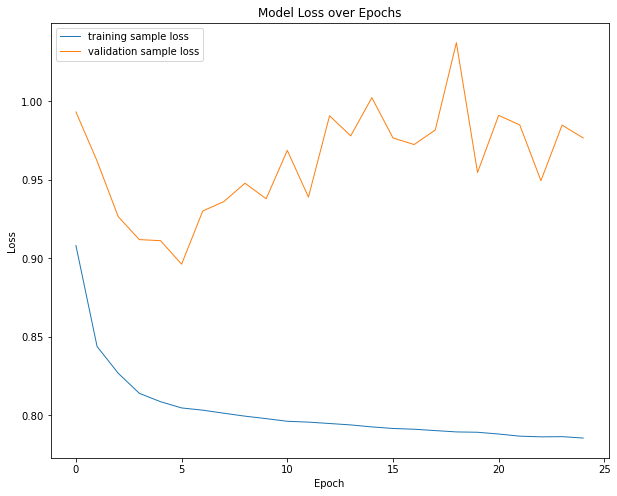

In [37]:
learningCurve(history)

In [38]:
model.save('lstm_small.h5')